In [717]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [718]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "TRF", "Submitted_for_Approval", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [719]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    #data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    #data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)

    return (data)

In [720]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [721]:
prep = preprocess(data, ada=True)

In [722]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [723]:
model = xgb.XGBClassifier(learning_rate = 0.015,
                          subsample=0.8,
                          colsample_bytree=0.5,
                          colsample_bylevel=0.8,
                          scale_pos_weight=0.69,
                          random_state=42,
                          max_depth=8,
                          booster = 'gbtree',
                          objective = 'binary:logistic',
                          n_estimators = 5000)

In [724]:
model.fit(x_train.drop(target, axis = 1), 
          y_train, eval_metric = 'logloss', 
          eval_set=[(x_test.drop(target, axis = 1), y_test)], 
          early_stopping_rounds = 200)

[0]	validation_0-logloss:0.680224
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.6677
[2]	validation_0-logloss:0.66131
[3]	validation_0-logloss:0.653528
[4]	validation_0-logloss:0.641825
[5]	validation_0-logloss:0.635085
[6]	validation_0-logloss:0.628185
[7]	validation_0-logloss:0.621372
[8]	validation_0-logloss:0.615152
[9]	validation_0-logloss:0.604369
[10]	validation_0-logloss:0.593892
[11]	validation_0-logloss:0.587919
[12]	validation_0-logloss:0.582638
[13]	validation_0-logloss:0.577145
[14]	validation_0-logloss:0.571391
[15]	validation_0-logloss:0.56166
[16]	validation_0-logloss:0.552159
[17]	validation_0-logloss:0.547318
[18]	validation_0-logloss:0.538229
[19]	validation_0-logloss:0.529467
[20]	validation_0-logloss:0.52089
[21]	validation_0-logloss:0.512438
[22]	validation_0-logloss:0.50758
[23]	validation_0-logloss:0.502714
[24]	validation_0-logloss:0.494682
[25]	validation_0-logloss:0.487024
[26]	validation_0-logloss:0.482984
[2

[230]	validation_0-logloss:0.114968
[231]	validation_0-logloss:0.114724
[232]	validation_0-logloss:0.114551
[233]	validation_0-logloss:0.114388
[234]	validation_0-logloss:0.113784
[235]	validation_0-logloss:0.113248
[236]	validation_0-logloss:0.113132
[237]	validation_0-logloss:0.112967
[238]	validation_0-logloss:0.112823
[239]	validation_0-logloss:0.112208
[240]	validation_0-logloss:0.111999
[241]	validation_0-logloss:0.111829
[242]	validation_0-logloss:0.111632
[243]	validation_0-logloss:0.111032
[244]	validation_0-logloss:0.110898
[245]	validation_0-logloss:0.110712
[246]	validation_0-logloss:0.110541
[247]	validation_0-logloss:0.110433
[248]	validation_0-logloss:0.109913
[249]	validation_0-logloss:0.109756
[250]	validation_0-logloss:0.109139
[251]	validation_0-logloss:0.108552
[252]	validation_0-logloss:0.108011
[253]	validation_0-logloss:0.107869
[254]	validation_0-logloss:0.1073
[255]	validation_0-logloss:0.107173
[256]	validation_0-logloss:0.107045
[257]	validation_0-logloss:0.1

[459]	validation_0-logloss:0.073917
[460]	validation_0-logloss:0.073798
[461]	validation_0-logloss:0.073739
[462]	validation_0-logloss:0.07366
[463]	validation_0-logloss:0.073587
[464]	validation_0-logloss:0.073518
[465]	validation_0-logloss:0.073498
[466]	validation_0-logloss:0.073411
[467]	validation_0-logloss:0.073367
[468]	validation_0-logloss:0.073311
[469]	validation_0-logloss:0.073192
[470]	validation_0-logloss:0.073147
[471]	validation_0-logloss:0.07306
[472]	validation_0-logloss:0.072996
[473]	validation_0-logloss:0.072951
[474]	validation_0-logloss:0.072901
[475]	validation_0-logloss:0.072854
[476]	validation_0-logloss:0.072758
[477]	validation_0-logloss:0.072714
[478]	validation_0-logloss:0.072629
[479]	validation_0-logloss:0.072546
[480]	validation_0-logloss:0.072476
[481]	validation_0-logloss:0.072381
[482]	validation_0-logloss:0.072297
[483]	validation_0-logloss:0.072251
[484]	validation_0-logloss:0.072164
[485]	validation_0-logloss:0.07204
[486]	validation_0-logloss:0.07

[688]	validation_0-logloss:0.063871
[689]	validation_0-logloss:0.063852
[690]	validation_0-logloss:0.063813
[691]	validation_0-logloss:0.063806
[692]	validation_0-logloss:0.06379
[693]	validation_0-logloss:0.063781
[694]	validation_0-logloss:0.063725
[695]	validation_0-logloss:0.063716
[696]	validation_0-logloss:0.0637
[697]	validation_0-logloss:0.063695
[698]	validation_0-logloss:0.063682
[699]	validation_0-logloss:0.063687
[700]	validation_0-logloss:0.063663
[701]	validation_0-logloss:0.063657
[702]	validation_0-logloss:0.063635
[703]	validation_0-logloss:0.063614
[704]	validation_0-logloss:0.06361
[705]	validation_0-logloss:0.063597
[706]	validation_0-logloss:0.063562
[707]	validation_0-logloss:0.06355
[708]	validation_0-logloss:0.063538
[709]	validation_0-logloss:0.063523
[710]	validation_0-logloss:0.063506
[711]	validation_0-logloss:0.063476
[712]	validation_0-logloss:0.063442
[713]	validation_0-logloss:0.063421
[714]	validation_0-logloss:0.063395
[715]	validation_0-logloss:0.0633

[917]	validation_0-logloss:0.060594
[918]	validation_0-logloss:0.060601
[919]	validation_0-logloss:0.060583
[920]	validation_0-logloss:0.060566
[921]	validation_0-logloss:0.060566
[922]	validation_0-logloss:0.060552
[923]	validation_0-logloss:0.060562
[924]	validation_0-logloss:0.060549
[925]	validation_0-logloss:0.060532
[926]	validation_0-logloss:0.060531
[927]	validation_0-logloss:0.060542
[928]	validation_0-logloss:0.060536
[929]	validation_0-logloss:0.060537
[930]	validation_0-logloss:0.060527
[931]	validation_0-logloss:0.060536
[932]	validation_0-logloss:0.060522
[933]	validation_0-logloss:0.060521
[934]	validation_0-logloss:0.060499
[935]	validation_0-logloss:0.060478
[936]	validation_0-logloss:0.060461
[937]	validation_0-logloss:0.060458
[938]	validation_0-logloss:0.060458
[939]	validation_0-logloss:0.060448
[940]	validation_0-logloss:0.060435
[941]	validation_0-logloss:0.060419
[942]	validation_0-logloss:0.060397
[943]	validation_0-logloss:0.060388
[944]	validation_0-logloss:0

[1142]	validation_0-logloss:0.059653
[1143]	validation_0-logloss:0.059677
[1144]	validation_0-logloss:0.059654
[1145]	validation_0-logloss:0.05966
[1146]	validation_0-logloss:0.059677
[1147]	validation_0-logloss:0.059689
[1148]	validation_0-logloss:0.059691
[1149]	validation_0-logloss:0.05968
[1150]	validation_0-logloss:0.059674
[1151]	validation_0-logloss:0.059677
[1152]	validation_0-logloss:0.059672
[1153]	validation_0-logloss:0.059668
[1154]	validation_0-logloss:0.059673
[1155]	validation_0-logloss:0.059681
[1156]	validation_0-logloss:0.05967
[1157]	validation_0-logloss:0.059659
[1158]	validation_0-logloss:0.059661
[1159]	validation_0-logloss:0.059654
[1160]	validation_0-logloss:0.059654
[1161]	validation_0-logloss:0.059643
[1162]	validation_0-logloss:0.059631
[1163]	validation_0-logloss:0.05962
[1164]	validation_0-logloss:0.059614
[1165]	validation_0-logloss:0.059605
[1166]	validation_0-logloss:0.059601
[1167]	validation_0-logloss:0.059601
[1168]	validation_0-logloss:0.059591
[1169

[1364]	validation_0-logloss:0.059675
[1365]	validation_0-logloss:0.059685
[1366]	validation_0-logloss:0.059677
[1367]	validation_0-logloss:0.059675
[1368]	validation_0-logloss:0.059665
[1369]	validation_0-logloss:0.059691
[1370]	validation_0-logloss:0.059684
[1371]	validation_0-logloss:0.059674
[1372]	validation_0-logloss:0.059676
[1373]	validation_0-logloss:0.059688
[1374]	validation_0-logloss:0.059691
[1375]	validation_0-logloss:0.059694
[1376]	validation_0-logloss:0.059694
[1377]	validation_0-logloss:0.059679
[1378]	validation_0-logloss:0.059676
[1379]	validation_0-logloss:0.059664
[1380]	validation_0-logloss:0.059655
[1381]	validation_0-logloss:0.059663
[1382]	validation_0-logloss:0.059663
[1383]	validation_0-logloss:0.059669
[1384]	validation_0-logloss:0.059681
[1385]	validation_0-logloss:0.059685
[1386]	validation_0-logloss:0.059686
[1387]	validation_0-logloss:0.059693
[1388]	validation_0-logloss:0.059706
[1389]	validation_0-logloss:0.0597
[1390]	validation_0-logloss:0.059691
[13

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.5, gamma=0, learning_rate=0.015,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=5000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.69, seed=None, silent=True,
       subsample=0.8)

In [725]:
res = model.predict_proba(x_test.drop(target, axis=1))[:,1]

In [726]:
x_test.Stage.head(10)

2040     0.0
4069     0.0
4230     1.0
578      1.0
12594    0.0
6042     1.0
2763     0.0
15900    0.0
2669     1.0
12802    0.0
Name: Stage, dtype: float64

In [727]:
for x in res[:10]:
    print("{:f}".format(x))

0.000276
0.007620
0.999090
0.995259
0.088678
0.956981
0.003218
0.000121
0.998649
0.001257


In [728]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [729]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [730]:
log_loss(answer["Stage"], answer["Prediction"])

0.06816188544505486

31


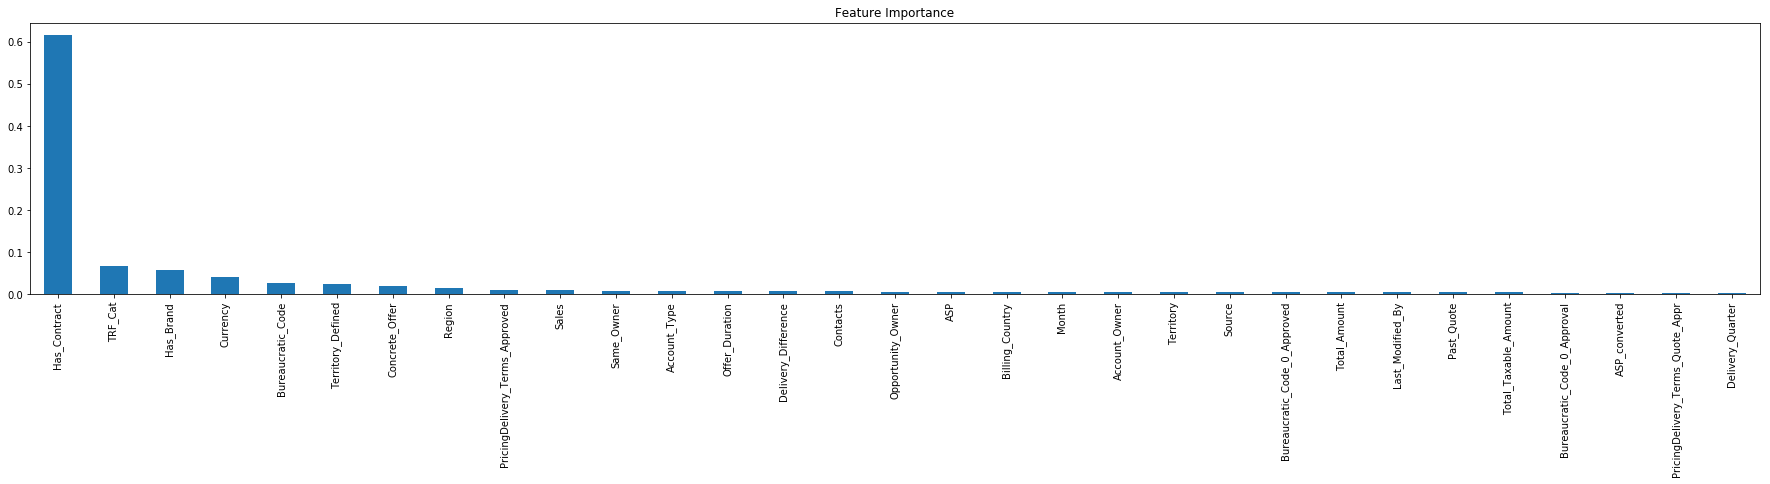

In [731]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:31]
plt.rcParams['figure.figsize'] = 31, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [732]:
print feat_imp

Has_Contract                        0.614663
TRF_Cat                             0.067774
Has_Brand                           0.057367
Currency                            0.040368
Bureaucratic_Code                   0.026426
Territory_Defined                   0.024699
Concrete_Offer                      0.018654
Region                              0.013894
PricingDelivery_Terms_Approved      0.010596
Sales                               0.010213
Same_Owner                          0.008301
Account_Type                        0.008078
Offer_Duration                      0.007943
Delivery_Difference                 0.007640
Contacts                            0.007517
Opportunity_Owner                   0.005634
ASP                                 0.005508
Billing_Country                     0.005489
Month                               0.005446
Account_Owner                       0.005278
Territory                           0.005042
Source                              0.004936
Bureaucrat

In [733]:
vali = pd.read_csv("Validacion_ECI_2020.csv")

In [734]:
validation = preprocess(vali, ada = True)

In [735]:
len(validation[validation.Contacts > 0])

2551

In [736]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))

In [737]:
pred_vali = pred[:,1]

In [738]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [739]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [740]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9972399865577121

In [741]:
#answer.to_csv("best/model_xgboost_pred.csv", index = False, header = False)